In [1]:
import networkx as nx
import random
random.seed(0)
import numpy as np
np.random.seed(0)

In [2]:
G = nx.erdos_renyi_graph(10,0.3,seed=1)

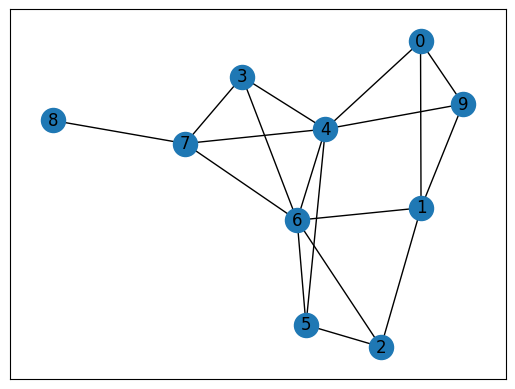

In [3]:
nx.draw_networkx(G)

In [4]:
def next_node(prev, curr, p, q):
    print(curr)
    nbrs = list(G.neighbors(curr))
    alphas = []
    for nbr in nbrs:
        if nbr == prev:
            alpha = 1/p
        elif G.has_edge(nbr,prev):
            alpha = 1
        else:
            alpha = 1/q
        alphas.append(alpha)
    probs = [alpha/sum(alphas) for alpha in alphas]
    n = np.random.choice(nbrs,size=1,p=probs)
    return n

In [5]:
def random_walk(start, length, p, q):
    curr = start
    prev = None
    walk = []
    walk.append(curr)
    for _ in range(length):
        nbr = next_node(prev, curr, p, q)
        prev = curr
        curr = nbr[0]
        walk.append(curr)
    return list(map(str,walk))

In [6]:
# !pip install node2vec

Building a movie RecSys

In [7]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

In [8]:
# url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
# with urlopen(url) as zurl:
#     with ZipFile(BytesIO(zurl.read())) as zfile:
#         zfile.extractall('.')

In [9]:
import pandas as pd

In [10]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestep'])

In [11]:
ratings

,user_id,movie_id,rating,unix_timestep
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [12]:
movies = pd.read_csv('ml-100k/u.item', sep='|', usecols=range(2), names=['movie_id', 'title'], encoding='latin-1')

In [13]:
movies

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [14]:
ratings=ratings[ratings.rating>=4]

In [15]:
ratings

,user_id,movie_id,rating,unix_timestep
5,298,474,4,884182806
7,253,465,5,891628467
11,286,1014,5,879781125
12,200,222,5,876042340
16,122,387,5,879270459
...,...,...,...,...
99988,421,498,4,892241344
99989,495,1091,4,888637503
99990,806,421,4,882388897
99991,676,538,4,892685437


In [16]:
from collections import defaultdict
pairs = defaultdict(int)

In [19]:
for group in ratings.groupby('user_id'):
    user_movies = list(group[1]["movie_id"])
    for i in range(len(user_movies)):
        for j in range(i+1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1

In [26]:
G = nx.Graph()

In [27]:
for pair in pairs:
    m1, m2 = pair
    score = pairs[pair]
    if score >= 20:
        G.add_edge(m1,m2,weight=score)

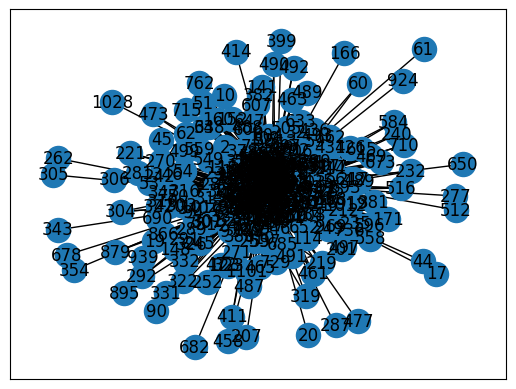

In [ ]:
nx.draw_networkx(G)

In [29]:
from node2vec import Node2Vec

In [31]:
n2v = Node2Vec(G, dimensions=64,walk_length=20,num_walks=200,p=2,q=1,workers=1)

Computing transition probabilities:   0%|          | 0/410 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:21<00:00,  9.28it/s]


In [32]:
model = n2v.fit(window=10,min_count=1,batch_words=4)

In [33]:
def recommend(movie):
    movie_id = str(movies[movies.title == movie].movie_id.values[0])
    for id in model.wv.most_similar(movie_id)[:5]:
        title = movies[movies.movie_id == (int(id[0]))].title.values[0]
        print(f"{title}:{id[1]:.2f}")

In [35]:
recommend("Star Wars (1977)")

Return of the Jedi (1983):0.63
Raiders of the Lost Ark (1981):0.55
Godfather, The (1972):0.50
Indiana Jones and the Last Crusade (1989):0.46
White Squall (1996):0.45
